# exp003 - 特徴量選択版モデル

exp001の特徴量重要度に基づき、上位7個の特徴量のみを使用してシンプル化。
過学習を軽減し、汎化性能の向上を目指す。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import japanize_matplotlib

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import lightgbm as lgb

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.rcParams['font.family'] = 'IPAexGothic'
sns.set_palette('husl')

## データの読み込みと前処理

exp001と同じ特徴量エンジニアリングを実行

In [2]:
# データの読み込み
train_df = pd.read_csv('../../data/train.csv')
test_df = pd.read_csv('../../data/test.csv')

print(f"訓練データ: {train_df.shape}")
print(f"テストデータ: {test_df.shape}")

# 全データを結合（特徴量エンジニアリングのため）
all_data = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)
print(f"全データ: {all_data.shape}")

訓練データ: (891, 12)
テストデータ: (418, 11)
全データ: (1309, 12)


In [ ]:
def feature_engineering(df):
    """
    exp001と同じ特徴量エンジニアリングを実行
    """
    df = df.copy()

    # 1. 称号（Title）の抽出
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

    # 称号のグルーピング
    title_mapping = {
        'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master',
        'Dr': 'Rare', 'Rev': 'Rare', 'Col': 'Rare', 'Major': 'Rare',
        'Mlle': 'Miss', 'Countess': 'Rare', 'Ms': 'Miss', 'Lady': 'Rare',
        'Jonkheer': 'Rare', 'Don': 'Rare', 'Dona': 'Rare', 'Mme': 'Mrs',
        'Capt': 'Rare', 'Sir': 'Rare'
    }
    df['Title'] = df['Title'].map(title_mapping)
    df['Title'] = df['Title'].fillna('Other')

    # 2. 家族サイズ
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

    # 3. 一人旅フラグ
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

    # 4. 家族サイズのカテゴリ化
    df['FamilySizeGroup'] = 'Medium'
    df.loc[df['FamilySize'] == 1, 'FamilySizeGroup'] = 'Alone'
    df.loc[df['FamilySize'] >= 5, 'FamilySizeGroup'] = 'Large'

    # 5. 年齢のビニング
    # 年齢の欠損値を称号で補完
    age_by_title = df.groupby('Title')['Age'].median()
    for title in age_by_title.index:
        df.loc[(df['Age'].isnull()) & (df['Title'] == title), 'Age'] = age_by_title[title]

    # 年齢をカテゴリ化
    df['AgeBin'] = pd.cut(df['Age'], bins=[0, 12, 20, 40, 120], labels=['Child', 'Teenager', 'Adult', 'Elder'])

    # 6. 運賃のビニング
    # 運賃の欠損値をクラスの中央値で補完
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    df['FareBin'] = pd.qcut(df['Fare'], q=4, labels=['Low', 'Medium', 'High', 'VeryHigh'])

    # 7. Cabinの有無
    df['HasCabin'] = df['Cabin'].notna().astype(int)

    # 8. 乗船港の欠損値補完
    df['Embarked'] = df['Embarked'].fillna('S')

    # 9. 性別×クラスの組み合わせ特徴量
    df['Sex_Pclass'] = df['Sex'] + '_' + df['Pclass'].astype(str)

    # 10. チケット番号の特徴量（参考程度）
    df['TicketPrefix'] = df['Ticket'].str.extract('([A-Za-z]+)', expand=False)
    df['TicketPrefix'] = df['TicketPrefix'].fillna('None')
    df['HasTicketPrefix'] = (df['TicketPrefix'] != 'None').astype(int)

    return df

# 特徴量エンジニアリングを実行
all_data = feature_engineering(all_data)
print("特徴量エンジニアリング完了")
print(f"全特徴量数: {all_data.shape[1]}")

特徴量エンジニアリング完了
全特徴量数: 22


In [4]:
# カテゴリカル変数をエンコード
categorical_features = ['Sex', 'Embarked', 'Title', 'FamilySizeGroup', 'AgeBin', 'FareBin', 'Sex_Pclass', 'TicketPrefix']

# Label Encoding
label_encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    all_data[feature] = le.fit_transform(all_data[feature].astype(str))
    label_encoders[feature] = le

print("ラベルエンコーディング完了")

ラベルエンコーディング完了


## 特徴量選択

exp001の特徴量重要度に基づき、上位7個の特徴量のみを選択

### exp001重要度ランキング
1. **Sex_Pclass**: 1463 （性別×クラス組み合わせ）
2. **Sex**: 878 （性別）
3. **Age**: 709 （年齢）
4. **Fare**: 536 （運賃）
5. **HasCabin**: 162 （客室情報有無）
6. **Pclass**: 157 （チケットクラス）
7. **Embarked**: 125 （乗船港）

### 除外される特徴量（重要度低）
- FamilySize: 118
- FareBin: 108
- Title: 99
- その他

In [5]:
# exp001の全特徴量（参考）
all_features = [
    'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
    'Title', 'FamilySize', 'IsAlone', 'FamilySizeGroup', 'AgeBin', 'FareBin',
    'HasCabin', 'Sex_Pclass', 'HasTicketPrefix'
]

# exp003で使用する特徴量（重要度上位7個）
selected_features = [
    'Sex_Pclass',  # 1位: 性別×クラス組み合わせ（最重要）
    'Sex',         # 2位: 性別
    'Age',         # 3位: 年齢
    'Fare',        # 4位: 運賃
    'HasCabin',    # 5位: 客室情報有無
    'Pclass',      # 6位: チケットクラス
    'Embarked'     # 7位: 乗船港
]

print(f"exp001 特徴量数: {len(all_features)}個")
print(f"exp003 選択特徴量数: {len(selected_features)}個")
print(f"削減数: {len(all_features) - len(selected_features)}個")

print("\n=== 選択した特徴量 ===")
for i, feature in enumerate(selected_features, 1):
    print(f"{i}. {feature}")

excluded_features = [f for f in all_features if f not in selected_features]
print("\n=== 除外した特徴量 ===")
for feature in excluded_features:
    print(f"- {feature}")

exp001 特徴量数: 16個
exp003 選択特徴量数: 7個
削減数: 9個

=== 選択した特徴量 ===
1. Sex_Pclass
2. Sex
3. Age
4. Fare
5. HasCabin
6. Pclass
7. Embarked

=== 除外した特徴量 ===
- SibSp
- Parch
- Title
- FamilySize
- IsAlone
- FamilySizeGroup
- AgeBin
- FareBin
- HasTicketPrefix


In [6]:
# 訓練・テストデータに分割
train_data = all_data[:len(train_df)].copy()
test_data = all_data[len(train_df):].copy()

# exp001（全特徴量）
X_all = train_data[all_features]
X_test_all = test_data[all_features]

# exp003（選択特徴量のみ）
X = train_data[selected_features]
y = train_data['Survived']
X_test = test_data[selected_features]

print(f"exp001 訓練データ特徴量: {X_all.shape}")
print(f"exp003 訓練データ特徴量: {X.shape}")
print(f"exp003 テストデータ特徴量: {X_test.shape}")

exp001 訓練データ特徴量: (891, 16)
exp003 訓練データ特徴量: (891, 7)
exp003 テストデータ特徴量: (418, 7)


## モデル訓練と比較

exp001のパラメータを使用して、特徴量数の違いによる効果を検証

In [7]:
# 訓練・検証データの分割
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 比較用のexp001データ
X_train_all, X_val_all, _, _ = train_test_split(
    X_all, y, test_size=0.2, random_state=42, stratify=y
)

print(f"exp003 訓練データ: {X_train.shape}")
print(f"exp003 検証データ: {X_val.shape}")
print(f"exp001 訓練データ: {X_train_all.shape}")
print(f"exp001 検証データ: {X_val_all.shape}")

exp003 訓練データ: (712, 7)
exp003 検証データ: (179, 7)
exp001 訓練データ: (712, 16)
exp001 検証データ: (179, 16)


In [8]:
# LightGBMパラメータ（exp001と同じ）
lgb_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42
}

print("=== モデル設定 ===")
print("LightGBMパラメータ: exp001と同じ設定を使用")
print("変更点: 特徴量数のみ（16個 → 7個）")

=== モデル設定 ===
LightGBMパラメータ: exp001と同じ設定を使用
変更点: 特徴量数のみ（16個 → 7個）


### exp001（全特徴量）での結果（参考）

In [9]:
print("=== exp001モデル訓練中（参考用） ===")

# exp001: 全特徴量でのモデル
train_dataset_all = lgb.Dataset(X_train_all, label=y_train)
val_dataset_all = lgb.Dataset(X_val_all, label=y_val, reference=train_dataset_all)

model_exp001 = lgb.train(
    lgb_params,
    train_dataset_all,
    num_boost_round=1000,
    valid_sets=[train_dataset_all, val_dataset_all],
    valid_names=['train', 'valid'],
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(100)]
)

# exp001の検証結果
y_pred_exp001 = model_exp001.predict(X_val_all, num_iteration=model_exp001.best_iteration)
y_pred_binary_exp001 = (y_pred_exp001 > 0.5).astype(int)
val_accuracy_exp001 = accuracy_score(y_val, y_pred_binary_exp001)

print(f"exp001（16特徴量）検証精度: {val_accuracy_exp001:.4f}")
print(f"exp001 最適イテレーション: {model_exp001.best_iteration}")

=== exp001モデル訓練中（参考用） ===
Training until validation scores don't improve for 100 rounds
[100]	train's binary_logloss: 0.230291	valid's binary_logloss: 0.461034
Early stopping, best iteration is:
[55]	train's binary_logloss: 0.300234	valid's binary_logloss: 0.443698
exp001（16特徴量）検証精度: 0.8212
exp001 最適イテレーション: 55


### exp003（選択特徴量）での結果

In [10]:
print("=== exp003モデル訓練中 ===")

# exp003: 選択特徴量でのモデル
train_dataset = lgb.Dataset(X_train, label=y_train)
val_dataset = lgb.Dataset(X_val, label=y_val, reference=train_dataset)

model_exp003 = lgb.train(
    lgb_params,
    train_dataset,
    num_boost_round=1000,
    valid_sets=[train_dataset, val_dataset],
    valid_names=['train', 'valid'],
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(100)]
)

# exp003の検証結果
y_pred_exp003 = model_exp003.predict(X_val, num_iteration=model_exp003.best_iteration)
y_pred_binary_exp003 = (y_pred_exp003 > 0.5).astype(int)
val_accuracy_exp003 = accuracy_score(y_val, y_pred_binary_exp003)

print(f"exp003（7特徴量）検証精度: {val_accuracy_exp003:.4f}")
print(f"exp003 最適イテレーション: {model_exp003.best_iteration}")

=== exp003モデル訓練中 ===
Training until validation scores don't improve for 100 rounds
[100]	train's binary_logloss: 0.257063	valid's binary_logloss: 0.487337
Early stopping, best iteration is:
[54]	train's binary_logloss: 0.322347	valid's binary_logloss: 0.468192
exp003（7特徴量）検証精度: 0.8156
exp003 最適イテレーション: 54


In [11]:
# 結果比較
print("=== 検証結果比較 ===")
print(f"exp001（16特徴量）検証精度: {val_accuracy_exp001:.4f}")
print(f"exp003（7特徴量） 検証精度: {val_accuracy_exp003:.4f}")
print(f"精度差: {val_accuracy_exp003 - val_accuracy_exp001:.4f}")
print(f"\n特徴量削減効果: {len(all_features)}個 → {len(selected_features)}個 ({len(all_features) - len(selected_features)}個削減)")

if val_accuracy_exp003 > val_accuracy_exp001:
    print("✅ 特徴量削減により精度が向上！")
elif abs(val_accuracy_exp003 - val_accuracy_exp001) < 0.001:
    print("➡️ 精度はほぼ同等（シンプル化の効果あり）")
else:
    print("❌ 特徴量削減により精度が低下")

=== 検証結果比較 ===
exp001（16特徴量）検証精度: 0.8212
exp003（7特徴量） 検証精度: 0.8156
精度差: -0.0056

特徴量削減効果: 16個 → 7個 (9個削減)
❌ 特徴量削減により精度が低下


## 分類レポート比較

In [12]:
print("=== exp001 分類レポート ===")
print(classification_report(y_val, y_pred_binary_exp001))

print("=== exp003 分類レポート ===")
print(classification_report(y_val, y_pred_binary_exp003))

=== exp001 分類レポート ===
              precision    recall  f1-score   support

         0.0       0.81      0.92      0.86       110
         1.0       0.84      0.67      0.74        69

    accuracy                           0.82       179
   macro avg       0.83      0.79      0.80       179
weighted avg       0.82      0.82      0.82       179

=== exp003 分類レポート ===
              precision    recall  f1-score   support

         0.0       0.81      0.92      0.86       110
         1.0       0.83      0.65      0.73        69

    accuracy                           0.82       179
   macro avg       0.82      0.79      0.80       179
weighted avg       0.82      0.82      0.81       179



## 混同行列比較

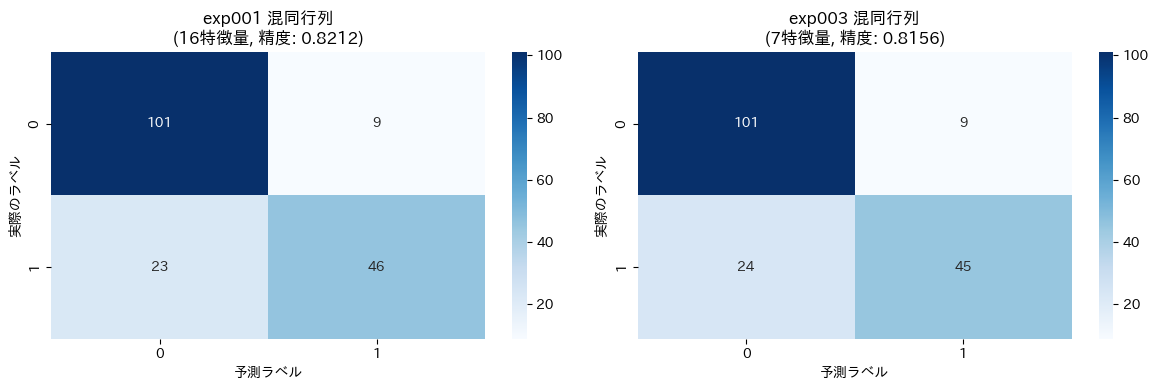

In [13]:
# 混同行列の比較可視化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# exp001
cm_exp001 = confusion_matrix(y_val, y_pred_binary_exp001)
sns.heatmap(cm_exp001, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title(f'exp001 混同行列\n(16特徴量, 精度: {val_accuracy_exp001:.4f})')
ax1.set_ylabel('実際のラベル')
ax1.set_xlabel('予測ラベル')

# exp003
cm_exp003 = confusion_matrix(y_val, y_pred_binary_exp003)
sns.heatmap(cm_exp003, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title(f'exp003 混同行列\n(7特徴量, 精度: {val_accuracy_exp003:.4f})')
ax2.set_ylabel('実際のラベル')
ax2.set_xlabel('予測ラベル')

plt.tight_layout()
plt.show()

## 5-fold クロスバリデーション比較

In [ ]:
# 5-fold クロスバリデーション
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cross_validate_model(X_data, model_name, feature_count):
    cv_scores = []
    print(f"=== {model_name} 5-fold CV ===")

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_data, y)):
        X_train_fold, X_val_fold = X_data.iloc[train_idx], X_data.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        # データセット作成
        train_dataset = lgb.Dataset(X_train_fold, label=y_train_fold)
        val_dataset = lgb.Dataset(X_val_fold, label=y_val_fold, reference=train_dataset)

        # モデル訓練
        fold_model = lgb.train(
            lgb_params,
            train_dataset,
            num_boost_round=1000,
            valid_sets=[val_dataset],
            callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
        )

        # 予測と評価
        y_pred_fold = fold_model.predict(X_val_fold, num_iteration=fold_model.best_iteration)
        y_pred_fold_binary = (y_pred_fold > 0.5).astype(int)
        fold_score = accuracy_score(y_val_fold, y_pred_fold_binary)
        cv_scores.append(fold_score)

        print(f"Fold {fold+1}: {fold_score:.4f}")

    cv_mean = np.mean(cv_scores)
    cv_std = np.std(cv_scores)
    print(f"{model_name} CV平均: {cv_mean:.4f} (+/- {cv_std*2:.4f})")
    return cv_mean, cv_std

# exp001とexp003のCV比較
cv_mean_exp001, cv_std_exp001 = cross_validate_model(X_all, "exp001", 16)
cv_mean_exp003, cv_std_exp003 = cross_validate_model(X, "exp003", 7)

=== exp001 5-fold CV ===
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[114]	valid_0's binary_logloss: 0.369859
Fold 1: 0.8603
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.377865
Fold 2: 0.8652
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.428052
Fold 3: 0.8315
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.398408
Fold 4: 0.8371
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[110]	valid_0's binary_logloss: 0.360075
Fold 5: 0.8539
exp001 CV平均: 0.8496 (+/- 0.0263)
=== exp003 5-fold CV ===
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[118]	valid_0's binary_logloss: 0.364234
Fold 1: 0.8492
T

In [15]:
print("=== クロスバリデーション結果比較 ===")
print(f"exp001（16特徴量）CV: {cv_mean_exp001:.4f} (+/- {cv_std_exp001*2:.4f})")
print(f"exp003（7特徴量） CV: {cv_mean_exp003:.4f} (+/- {cv_std_exp003*2:.4f})")
print(f"CV平均差: {cv_mean_exp003 - cv_mean_exp001:.4f}")
print(f"標準偏差変化: {cv_std_exp001:.4f} → {cv_std_exp003:.4f} ({cv_std_exp003 - cv_std_exp001:.4f})")

# 安定性の評価
if cv_std_exp003 < cv_std_exp001:
    print("✅ モデルがより安定的になりました")
else:
    print("⚠️ モデルの安定性は変わらないか、わずかに悪化")

=== クロスバリデーション結果比較 ===
exp001（16特徴量）CV: 0.8496 (+/- 0.0263)
exp003（7特徴量） CV: 0.8316 (+/- 0.0411)
CV平均差: -0.0180
標準偏差変化: 0.0131 → 0.0206 (0.0074)
⚠️ モデルの安定性は変わらないか、わずかに悪化


## 特徴量重要度分析

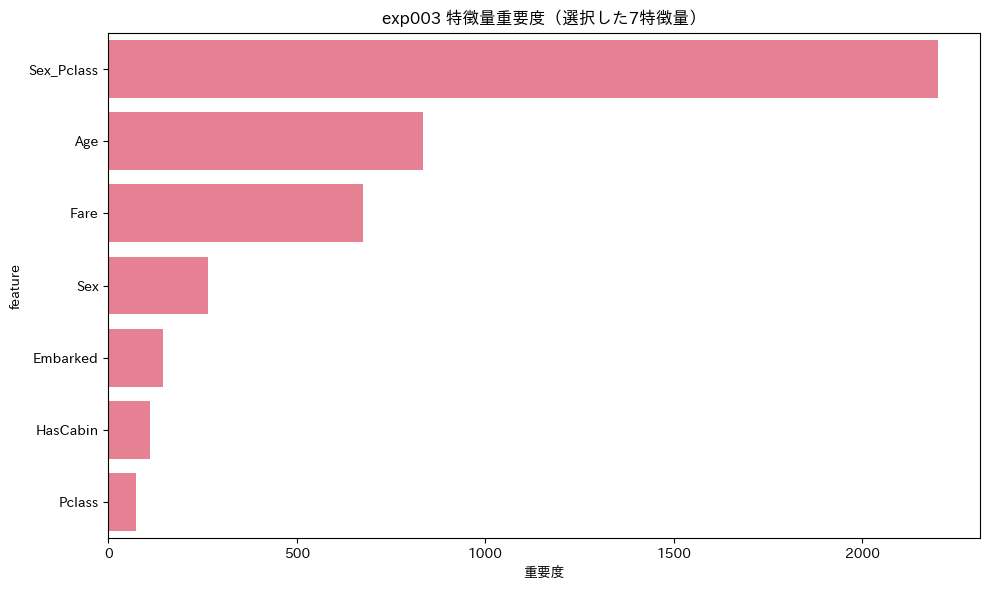

=== exp003 特徴量重要度 ===
1. Sex_Pclass  :     2202
3. Age         :      835
4. Fare        :      676
2. Sex         :      264
7. Embarked    :      145
5. HasCabin    :      112
6. Pclass      :       75


In [16]:
# exp003の特徴量重要度
importance_exp003 = model_exp003.feature_importance(importance_type='gain')
feature_importance_exp003 = pd.DataFrame({
    'feature': selected_features,
    'importance': importance_exp003
}).sort_values('importance', ascending=False)

# 特徴量重要度の可視化
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_exp003, x='importance', y='feature')
plt.title('exp003 特徴量重要度（選択した7特徴量）')
plt.xlabel('重要度')
plt.tight_layout()
plt.show()

print("=== exp003 特徴量重要度 ===")
for i, row in feature_importance_exp003.iterrows():
    print(f"{i+1}. {row['feature']:12s}: {row['importance']:8.0f}")

## テストデータでの予測

In [17]:
# 全訓練データでexp003モデルを再訓練
print("=== exp003最終モデル訓練中 ===")
full_train_dataset = lgb.Dataset(X, label=y)
final_model_exp003 = lgb.train(
    lgb_params,
    full_train_dataset,
    num_boost_round=model_exp003.best_iteration
)

# テストデータで予測
test_predictions_exp003 = final_model_exp003.predict(X_test)
test_predictions_binary_exp003 = (test_predictions_exp003 > 0.5).astype(int)

print(f"exp003 テスト予測完了")
print(f"生存予測数: {test_predictions_binary_exp003.sum()}")
print(f"死亡予測数: {len(test_predictions_binary_exp003) - test_predictions_binary_exp003.sum()}")
print(f"生存率: {test_predictions_binary_exp003.mean():.4f}")

=== exp003最終モデル訓練中 ===
exp003 テスト予測完了
生存予測数: 137
死亡予測数: 281
生存率: 0.3278


## 提出ファイルの作成

In [18]:
# 提出ファイルの作成
submission_exp003 = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': test_predictions_binary_exp003
})

# results/exp003ディレクトリを作成
import os
os.makedirs('../../results/exp003', exist_ok=True)

# ファイルを保存
submission_exp003.to_csv('../../results/exp003/submission.csv', index=False)
print("提出ファイルを保存しました: ../../results/exp003/submission.csv")

# 提出ファイルの確認
print("\n提出ファイルの最初の10行:")
print(submission_exp003.head(10))

提出ファイルを保存しました: ../../results/exp003/submission.csv

提出ファイルの最初の10行:
     PassengerId  Survived
891          892         0
892          893         0
893          894         0
894          895         0
895          896         0
896          897         0
897          898         1
898          899         0
899          900         1
900          901         0


## 実験結果まとめ

### 特徴量選択の効果

#### 変更内容
- **特徴量数**: 16個 → 7個（9個削減）
- **選択基準**: exp001の特徴量重要度上位7個
- **モデルパラメータ**: exp001と同じ設定を維持

#### 選択した特徴量
1. Sex_Pclass（性別×クラス組み合わせ）
2. Sex（性別）
3. Age（年齢）
4. Fare（運賃）
5. HasCabin（客室情報有無）
6. Pclass（チケットクラス）
7. Embarked（乗船港）

#### 除外した特徴量
- FamilySize, FareBin, Title, IsAlone, FamilySizeGroup, AgeBin, SibSp, Parch, HasTicketPrefix

### 期待される効果
- **シンプル化**: ノイズとなる特徴量の除去
- **汎化性能向上**: 重要な特徴量に集中
- **過学習軽減**: 特徴量数削減による複雑度低下
- **解釈しやすさ**: より少ない特徴量での説明

### 次のステップ
- Kaggleでの実際のスコア確認
- CVとKaggleスコアのギャップ縮小効果を検証
- 必要に応じてさらなる改善手法の検討